# UK Crime Data Analysis (May 2024 – May 2025)

This project explores a full year of UK crime data (May 2024 to May 2025), downloaded from [data.police.uk](https://data.police.uk). 

This project also uses data from [Naturalearthdata.com](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/) for Admin 0 - Countries
 
Over 500 CSV files — each corresponding to a constituency per month — were combined to build a geospatially enriched dataset. This notebook covers:

- Data ingestion and cleaning
- Exploratory data analysis (EDA)
- Mapping crime hotspots (heatmap and choropleth)
- Identifying top crime types

## Data Ingestion

We use `glob` to recursively load all `.csv` files from the directory into a single `pandas` DataFrame.


In [1]:
import pandas as pd
import os
from glob import glob

root_path = 'C:/Users/Matthew/Documents/A Portfolio Data Analysis Projects/Data/Police Data/May24-May25/'

all_csvs = glob(os.path.join(root_path, "**", "*.csv"), recursive= True) # Recursively collecting all CSV File paths

crime_df = pd.concat([pd.read_csv(file) for file in all_csvs], ignore_index=True) # Loading and concatenating into one single DataFrame

## Initial Data Exploration

We begin by examining the structure and contents of the combined dataset.


In [2]:
# High level, basic overview
print(f"Total rows loaded: {len(crime_df)}")
print(crime_df.info())

# Top 5 types of crime
crime_counts = crime_df["Crime type"].value_counts()
print("Top 5 Crime Types:")
print(crime_counts.head())


Total rows loaded: 6318684
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6318684 entries, 0 to 6318683
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Crime ID               object 
 1   Month                  object 
 2   Reported by            object 
 3   Falls within           object 
 4   Longitude              float64
 5   Latitude               float64
 6   Location               object 
 7   LSOA code              object 
 8   LSOA name              object 
 9   Crime type             object 
 10  Last outcome category  object 
 11  Context                float64
dtypes: float64(3), object(9)
memory usage: 578.5+ MB
None
Top 5 Crime Types:
Crime type
Violence and sexual offences    2169529
Anti-social behaviour            999768
Shoplifting                      534467
Criminal damage and arson        461324
Public order                     448413
Name: count, dtype: int64


In [3]:
#Null Value Validation
crime_df.isnull().sum().sort_values(ascending=False)
#Null Crime ID is irrelevant since not useful. Could drop column for storage. Location null is irrelevant since we have logitude and latitude. Last outcome and context irrelevant since not useful in this scenario.
columns_to_drop = ['Crime ID','Location','Last outcome category', 'Context']
crime_df = crime_df.drop(columns=columns_to_drop)

crime_df.info() #190mb saved

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6318684 entries, 0 to 6318683
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Month         object 
 1   Reported by   object 
 2   Falls within  object 
 3   Longitude     float64
 4   Latitude      float64
 5   LSOA code     object 
 6   LSOA name     object 
 7   Crime type    object 
dtypes: float64(2), object(6)
memory usage: 385.7+ MB


In [4]:
#crime_df.isnull().sum().sort_values(ascending=False) #94,949 LSOA nulls and 93,844 Longitude/Latitude nulls

#Preparing data for GeoDataFrame
crime_df = crime_df.dropna(subset=['Longitude','Latitude'])

crime_df.isnull().sum().sort_values(ascending=False) #1,105 remaining LSOA names and codes as null. They have coordinates, so still useful for now.

LSOA name       1105
LSOA code       1105
Month              0
Reported by        0
Longitude          0
Falls within       0
Latitude           0
Crime type         0
dtype: int64

## Converting to a GeoDataFrame

We drop rows with missing coordinates and convert the DataFrame into a `GeoDataFrame` using `GeoPandas`.


In [5]:
import geopandas as gpd
from shapely.geometry import Point

#Converting coordinates to spatial geometric points.
geometry = [Point(xy) for xy in zip(crime_df.Longitude, crime_df.Latitude)]
geo_df = gpd.GeoDataFrame(crime_df, geometry=geometry)


## Crime Density Heatmap

We use the geospatial coordinates to plot a heatmap of crime density across the UK.

In [18]:
#Creating UK World map reference
shapefile_path = "C:/Users/Matthew/Documents/A Portfolio Data Analysis Projects/Data/Police Data/World Map Data/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
united_kingdom = world[world['ADMIN'] == 'United Kingdom']

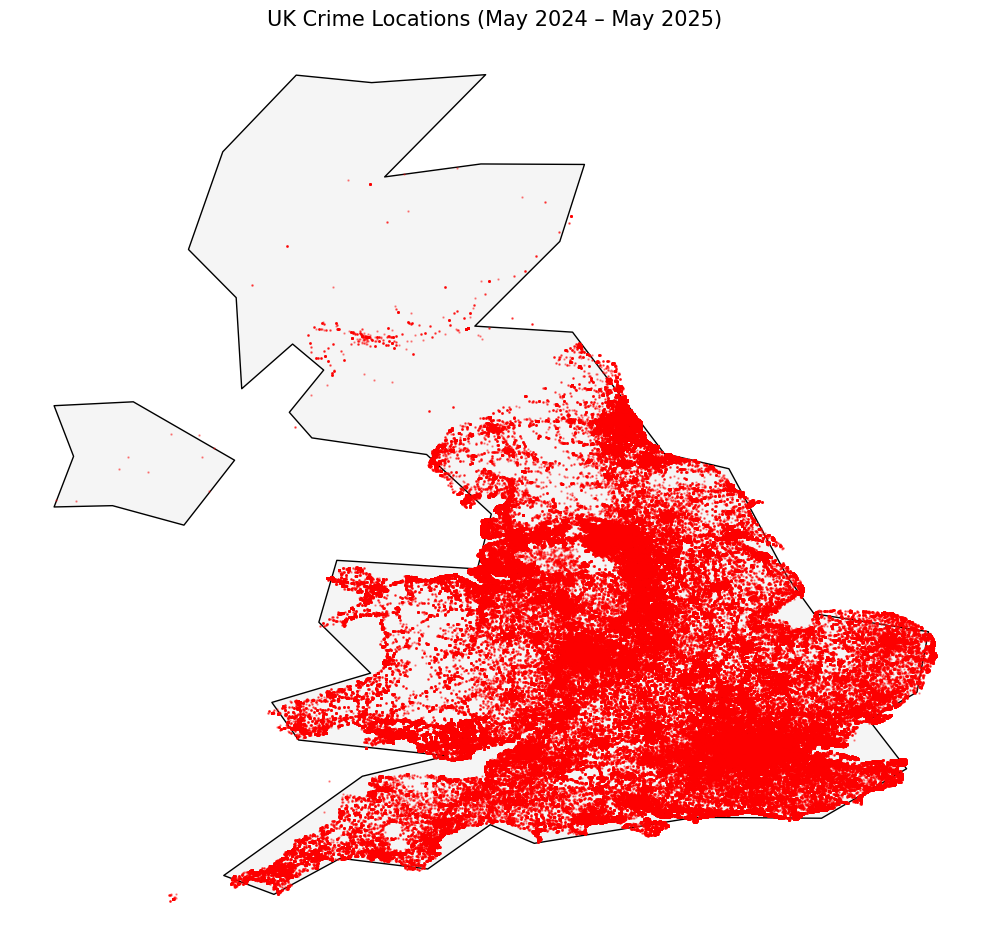

In [19]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Plot
fig, ax = plt.subplots(figsize=(10, 14))
united_kingdom.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot crime points
geo_df.plot(ax=ax, markersize=0.5, color='red', alpha=0.4)

# Style
plt.title("UK Crime Locations (May 2024 – May 2025)", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()


## Choropleth by Local Authority District

This section aggregates crime data by LAD (Local Authority District) and overlays it onto a UK shapefile to visualise regional differences.


In [8]:
#Group the data by 'LSOA code' and 'LSOA name', and count the number of crimes in each group
crime_counts = crime_df.groupby(['LSOA code', 'LSOA name']).size().reset_index(name='Crime Count')

#Sort the data in descending order based on the 'Crime Count' column and display the top 5 rows
print(crime_counts.sort_values(by='Crime Count', ascending=False).head())


       LSOA code            LSOA name  Crime Count
32434  E01035716     Westminster 013G        16476
4499   E01004763     Westminster 013B        12227
4475   E01004734     Westminster 018A        11410
30056  E01033010           Leeds 111B         8584
29857  E01032739  City of London 001F         8046


In [9]:
# Read the datasets
lsoa_electoral = pd.read_csv("C:/Users/Matthew/Documents/A Portfolio Data Analysis Projects/Data/Police Data/LSOA and LAD data/LSOA_2021_TO_LAD_2025.csv")
lsoa = gpd.read_file("C:/Users/Matthew/Documents/A Portfolio Data Analysis Projects/Data/Police Data/LSOA and LAD data/LAD_Data/LAD_MAY_2025_UK_BFE.shp")

# Display columns to verify that the relevant columns exist for merging
#print(lsoa.columns)
#print(lsoa_electoral.columns)

# Rename 'LSOA code' to 'LSOA21CD' for consistency across datasets
crime_df = crime_df.rename(columns={'LSOA code': 'LSOA21CD'})

# Merge the 'crime_df' with 'lsoa_electoral' on 'LSOA21CD' column
crime_with_LAD = crime_df.merge(
    lsoa_electoral[['LSOA21CD', 'LAD25CD', 'LAD25NM']],  # Select relevant columns
    on='LSOA21CD',  # Merge on the 'LSOA21CD' column
    how='left'  # Perform a left join to keep all rows from crime_df
)

# Display the first few rows of the merged dataframe for a sanity check
print(crime_with_LAD[['LSOA21CD', 'LAD25CD', 'LAD25NM']].head())


    LSOA21CD    LAD25CD                       LAD25NM
0  E01014399  E06000022  Bath and North East Somerset
1  E01014399  E06000022  Bath and North East Somerset
2  E01014399  E06000022  Bath and North East Somerset
3  E01014399  E06000022  Bath and North East Somerset
4  E01014399  E06000022  Bath and North East Somerset


In [17]:
#Aggregate crime by LAD
crime_by_lad = crime_with_LAD.groupby(by=['LAD25CD', 'LAD25NM']).size().reset_index(name='Crime Count')

#Now check the data:
print(crime_by_lad.sort_values('Crime Count', ascending=False).head())

       LAD25CD           LAD25NM  Crime Count
248  E08000025        Birmingham       164796
258  E08000035             Leeds       120701
295  E09000033       Westminster       110442
255  E08000032          Bradford        82953
22   E06000023  Bristol, City of        74769


In [11]:
#Now create the shapefile dataframe with the LAD codes, so we can plot it graphically

#Compare columns:
#print(lsoa.columns)
#print(crime_by_lad.columns)
#LAD25CD is the same in both tables

lad_geo = lsoa.merge(
     crime_by_lad
    ,on='LAD25CD'
    ,how='left'
)

Now we have the data grouped by local authority district, so we can break it down further which parts of the UK (although this data seems to primarily focus on Wales and England)

After some research, I believe a chloropleth map will be the most interesting way to plot the data. This is because a chloropleth map allows you to visualise how a variable varies across a geographic area (local authority)

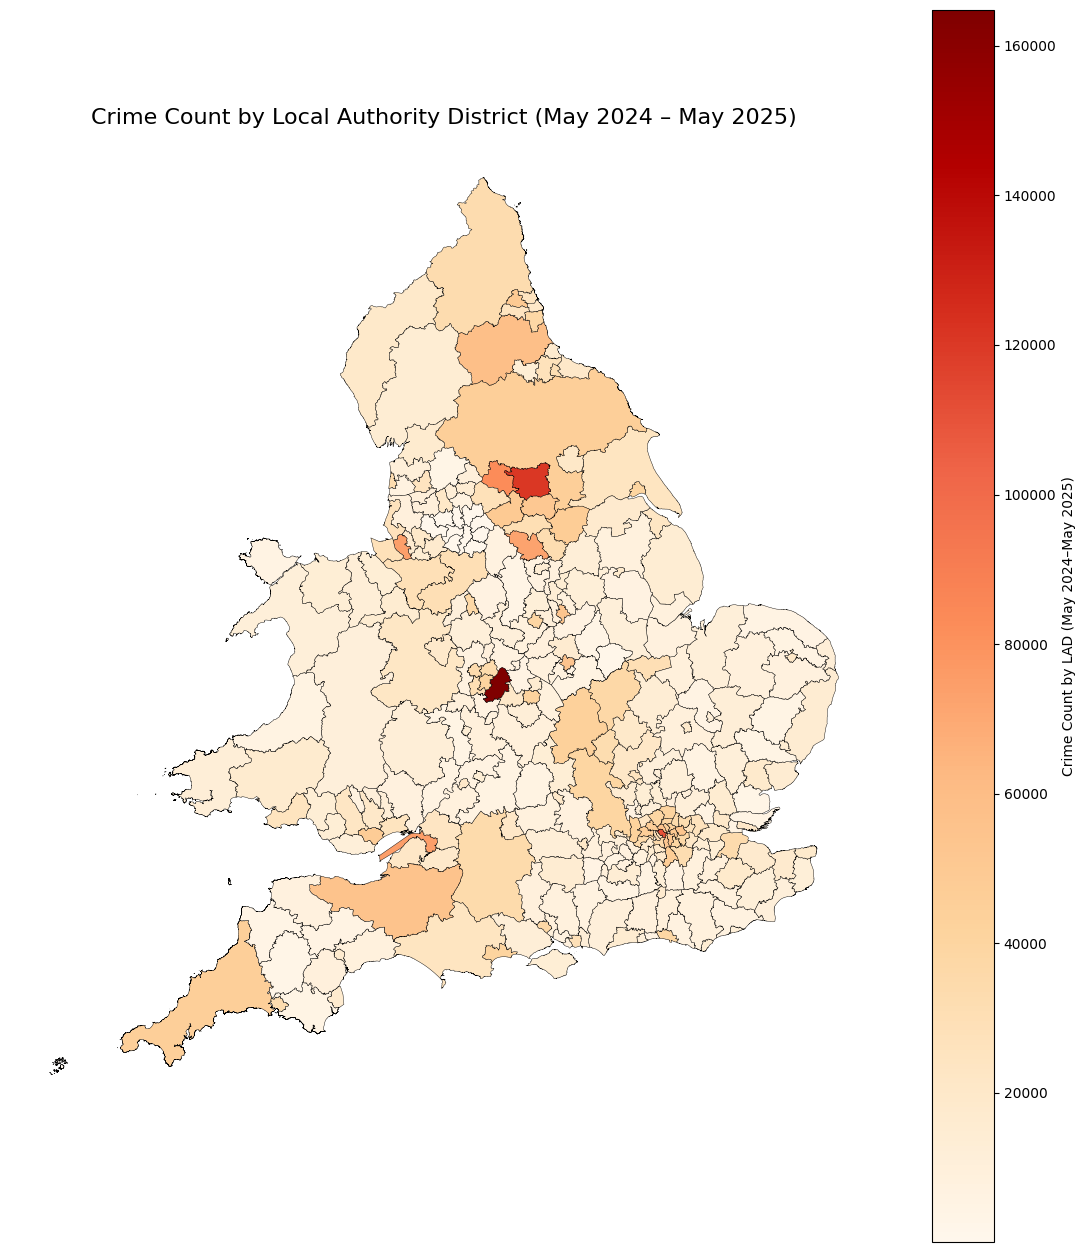

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 16))
lad_geo.plot( #with GeoPandas .plot is default choropleth map.
    column='Crime Count',
    ax=ax,
    legend=True, #Allows you to interpret the shading/heatmap
    cmap='OrRd', #Orange/Red Heatmap
    edgecolor='black', #To see visibility between LAD
    linewidth=0.3,
    legend_kwds={'label': "Crime Count by LAD (May 2024–May 2025)"}
)

ax.set_title("Crime Count by Local Authority District (May 2024 – May 2025)", fontsize=16)
ax.axis('off')
plt.show()

## Most Common Crime Types

Visualising the top 10 crime categories across the UK, from May 2024 to May 2025.

(Displayed on a wider and shorter graph with straight and angled text for monitor size variability)

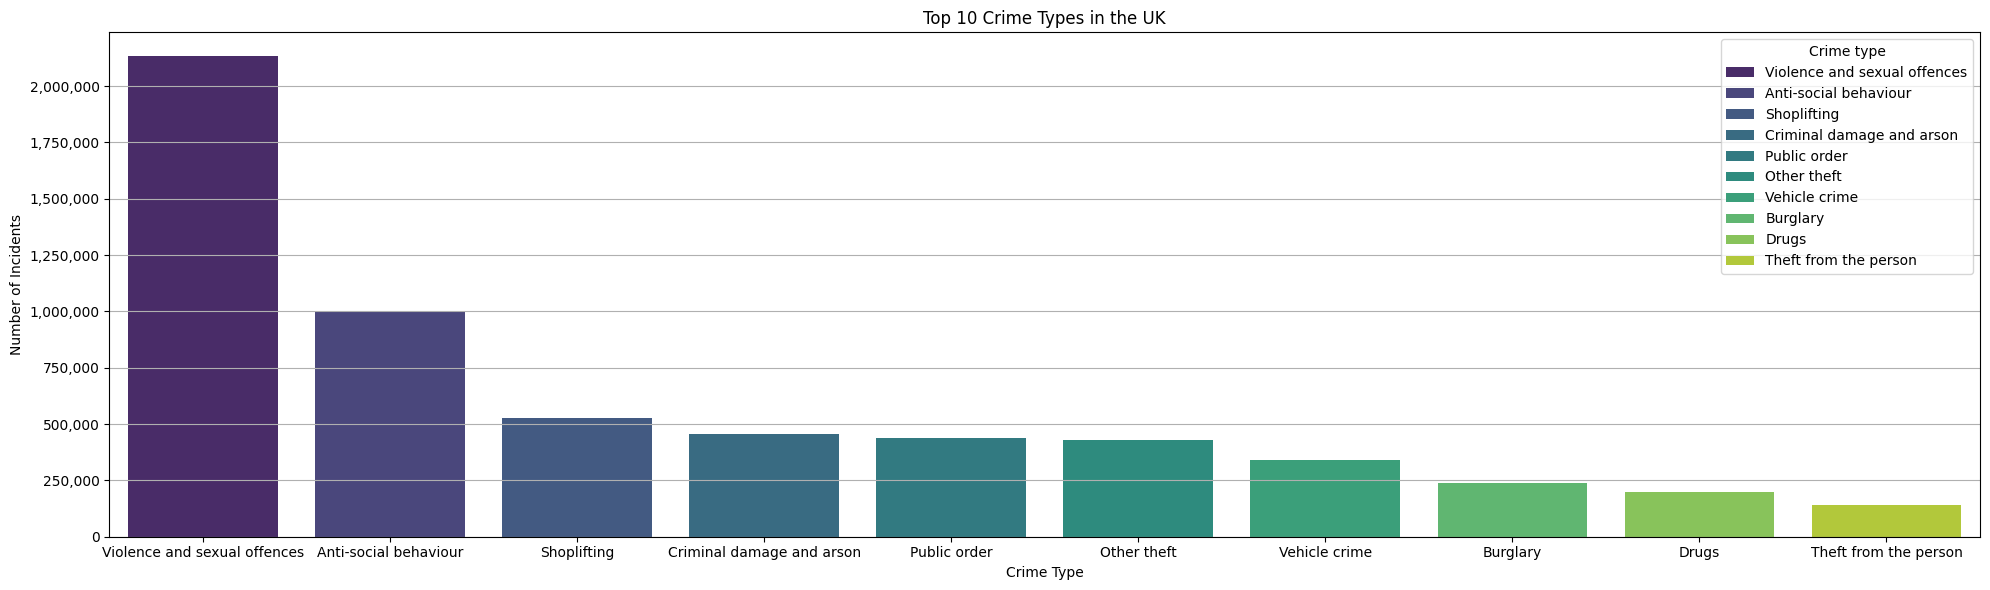

In [13]:
import seaborn as sns
from matplotlib.ticker import FuncFormatter
#Option A on displaying.

# Formatting for top left scale in barplot (1e6 to 1,000,000)
def millions(x, pos):
    return f'{x:,.0f}'

# Create the figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Get the top 10 most common crime types
top_crimes = crime_df["Crime type"].value_counts().head(10)

# Seaborn barplot with palette to show even more clearly the unique crime types.
sns.barplot(x=top_crimes.index, y=top_crimes.values, ax=ax, palette='viridis', hue=top_crimes.index, legend=True)

# Title and labels
plt.title("Top 10 Crime Types in the UK")
plt.ylabel("Number of Incidents")
plt.xlabel("Crime Type")
plt.xticks(rotation=0)
ax.yaxis.set_major_formatter(FuncFormatter(millions))

# Add gridlines for better readability
plt.grid(axis='y')
#make less bold if possible

# Make sure the layout adjusts to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

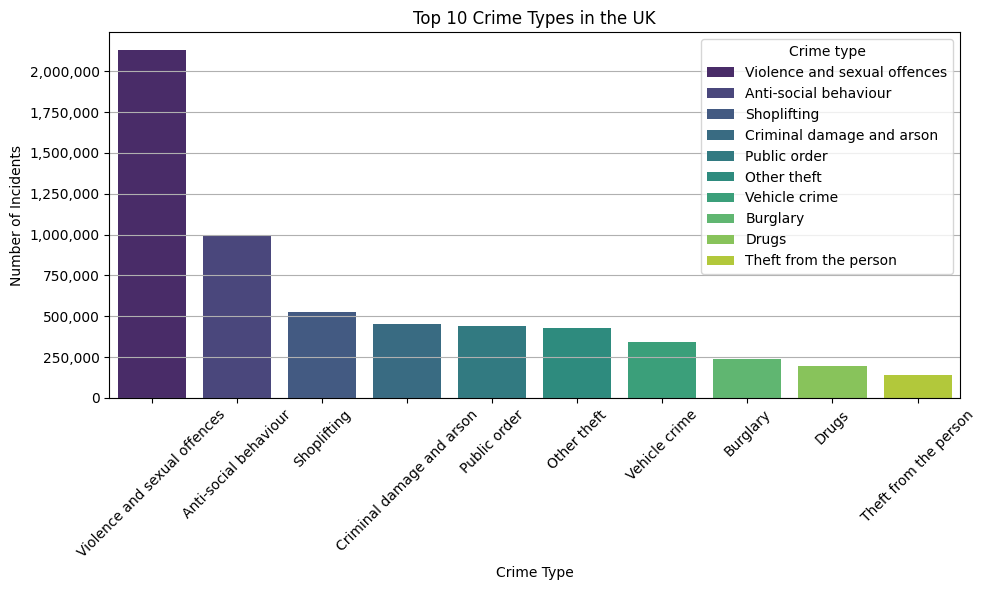

In [14]:
#Option B on displaying.
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Get the top 10 most common crime types
top_crimes = crime_df["Crime type"].value_counts().head(10)

# Seaborn barplot with palette to show even more clearly the unique crime types.
sns.barplot(x=top_crimes.index, y=top_crimes.values, ax=ax, palette='viridis', hue=top_crimes.index, legend=True)

# Title and labels
plt.title("Top 10 Crime Types in the UK")
plt.ylabel("Number of Incidents")
plt.xlabel("Crime Type")
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(millions))

# Add gridlines for better readability
plt.grid(axis='y')

# Make sure the layout adjusts to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Summary of Key Findings

- **Violence and Sexual Offences** dominate UK crime reports, with over 2.17 million incidents.
- **Anti-social behaviour** and **shoplifting** follow as the next most common crimes.
- **Birmingham** is the LAD with the highest crime volume (~160k), followed by **Leeds** (~120k) and **Westminster** (~110k).
- Heatmap and choropleth visualisations reveal significant regional clustering of crime.


## Future Improvements

- Compare with previous year’s dataset (May 2023 – May 2024) to identify year-on-year crime trends.
- Normalise crime counts by population to assess per-capita crime rates.
- Add predictive modelling (e.g. time series forecasting or clustering by region/crime type).
